# 预训练word2vec


In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size,
                                     num_noise_words)

In [2]:
# 只需要在notebook最开始运行一次
import d2l.torch
import torch
from torch.utils.data import DataLoader

# 保存原始函数（可选，但建议）
original_load_data = d2l.torch.load_data_ptb

# 定义全局Dataset类
class PTBDataset(torch.utils.data.Dataset):
    def __init__(self, centers, contexts, negatives):
        assert len(centers) == len(contexts) == len(negatives)
        self.centers = centers
        self.contexts = contexts
        self.negatives = negatives

    def __getitem__(self, index):
        return (self.centers[index], self.contexts[index], self.negatives[index])

    def __len__(self):
        return len(self.centers)

# 替换d2l的函数
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """修复版：使用全局PTBDataset"""
    sentences = d2l.torch.read_ptb()
    vocab = d2l.torch.Vocab(sentences, min_freq=10)
    subsampled, counter = d2l.torch.subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = d2l.torch.get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = d2l.torch.get_negatives(
        all_contexts, vocab, counter, num_noise_words)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)
    
    num_workers = 0
    data_iter = DataLoader(
        dataset, batch_size, shuffle=True,
        collate_fn=d2l.torch.batchify, num_workers=num_workers)
    return data_iter, vocab

d2l.torch.load_data_ptb = load_data_ptb

# 现在可以正常使用了！
data_iter, vocab = d2l.torch.load_data_ptb(batch_size=512, max_window_size=5, num_noise_words=5)

## 跳元模型
### 嵌入层


```python
索引:  0      1      2      ...    19
      ↓      ↓      ↓             ↓
    [0.1,  0.2,  0.3,  ...,  0.4]  ← 维度1
    [0.5,  0.6,  0.7,  ...,  0.8]  ← 维度2
    [0.9,  1.0,  1.1,  ...,  1.2]  ← 维度3
    [1.3,  1.4,  1.5,  ...,  1.6]  ← 维度4
```

In [3]:
'''
1. 创建嵌入层
num_embeddings=20：
词汇表大小：可以表示20个不同的词元
索引范围：有效输入是整数0到19
权重矩阵形状：(20,4)
embedding_dim=4：
每个词向量的维度：4维稠密向量
数值含义：每个维度是待学习的连续值
'''
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
# 2. 查看权重参数
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


嵌入层的输入是词元（词）的索引。对于任何词元索引$i$，其向量表示可以从嵌入层中的权重矩阵的第$i$行获得。由于向量维度（`output_dim`）被设置为4，因此当小批量词元索引的形状为（2，3）时，嵌入层返回具有形状（2，3，4）的向量。


**执行过程**
```Python
x = torch.tensor([[1, 2, 3], [4, 5, 6]])  # 形状 (2, 3)
embed(x)  # 查询每个索引对应的词向量
```
**维度变化**
```python
输入 x: (2, 3)  # 2个样本，每个样本3个词元索引
    ↓ embed
输出:   (2, 3, 4)  # 2个样本，每个样本3个词元，每个词元4维向量
```
**输出示例**
```python
tensor([[
    [ 0.12, -0.34,  0.56,  0.78],  # 索引1的向量
    [-0.23,  0.45, -0.67,  0.89],  # 索引2的向量
    [ 0.34, -0.56,  0.78, -0.90]   # 索引3的向量
], [
    [-0.45,  0.67, -0.89,  0.12],  # 索引4的向量
    [ 0.56, -0.78,  0.90, -0.12],  # 索引5的向量
    [-0.67,  0.89, -0.12,  0.34]   # 索引6的向量
]])
```

In [4]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

tensor([[[-2.7578,  0.5032, -0.8988, -1.1917],
         [-2.0801, -0.9175,  0.2871,  1.5329],
         [ 0.4094, -0.5684,  0.9572,  0.7031]],

        [[ 0.1388,  2.0402, -0.8986, -0.3572],
         [-1.1735,  1.5062,  0.1714,  0.7477],
         [ 0.7394, -0.6142, -1.3062, -0.0223]]], grad_fn=<EmbeddingBackward0>)

### 定义前向传播


In [5]:
'''
center：中心词索引，形状(batch_size,1)
contexts_and_negatives：上下文词+负样本词索引，形状(batch_size,max_len)
embed_v：中心词嵌入层（nn.Embedding）
embed_u：上下文词嵌入层（nn.Embedding）
'''
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    '''
    1. 获取中心词向量
    输入：center形状(batch_size,1)，如tensor([[245],[1123]])
    输出：v形状(batch_size,1,embed_dim)，如(32,1,100)
    作用：将中心词索引映射为稠密向量
    '''
    v = embed_v(center)
    '''
    2. 获取上下文/负样本词向量
    输入：contexts_and_negatives形状(batch_size,max_len)
        示例：tensor([[1024,380,3,1,2],[2045,3,1,0,0]])（正样本+负样本+填充）
    输出：u形状(batch_size,max_len,embed_dim)，如(32,5,100)
    作用：将所有上下文/负样本词映射为向量
    '''
    u = embed_u(contexts_and_negatives)
    '''
    3. 计算相似度分数
    u.permute(0,2,1)：调整u的维度
    原形状：(batch_size,max_len,embed_dim)，如(32,5,100)
    新形状：(batch_size,embed_dim,max_len)，如(32,100,5)
    目的：将最后一个维度变为max_len，便于矩阵乘法
    torch.bmm：批量矩阵乘法
    v形状：(batch_size,1,embed_dim)，如(32,1,100)
    u.permute(...)形状：(batch_size,embed_dim,max_len)，如(32,100,5)
    输出：(batch_size,1,max_len)，如(32,1,5)
    含义：每个中心词与每个上下文/负样本词的点积相似度
    '''
    pred = torch.bmm(v, u.permute(0, 2, 1))
    '''
    4. 返回预测
    输出形状：(batch_size,1,max_len)
    示例：tensor([[0.8,-0.3,0.1,-0.5,0.2]])
        0.8：与第一个上下文词（正样本）的相似度
        -0.3：与第一个负样本的相似度
        以此类推...
    '''
    return pred

**维度变化流程**
1. v = embed_v(center)
```Python
center: tensor([[1], [1]])                # 形状 (2, 1)
v = embed(center)                         # 查表
# 输出: v 形状 (2, 1, 4)
解释：2个样本，每个1个中心词，每个词向量为4维
```
2. u = embed_u(contexts_and_negatives)
```Python
contexts_and_negatives: tensor([[1,1,1,1], [1,1,1,1]])  # 形状 (2, 4)
u = embed(contexts_and_negatives)                     # 查表
# 输出: u 形状 (2, 4, 4)
解释：2个样本，每个4个上下文/负样本词，每个词向量为4维
```
3. u.permute(0, 2, 1)
```Python
u: (2, 4, 4)
u.permute(0, 2, 1) → (2, 4, 4)
转置：将最后两个维度交换，以便后续矩阵乘法
```
4. torch.bmm(v, u.permute(...))
```Python
v: (2, 1, 4)
u.permute: (2, 4, 4)
torch.bmm(v, u.permute) → (2, 1, 4)
```
- 批量矩阵乘法：对每个样本
    - 样本0:  (1×4) @ (4×4)  → (1×4)
    - 样本1:  (1×4) @ (4×4)  → (1×4)
- 结果：(batch_size, 1, max_len) = (2, 1, 4)
**输出形状推理**
```Python
pred = skip_gram(...)
print(pred.shape)  # 输出: torch.Size([2, 1, 4])
```
最终形状：(batch_size, 1, max_len)
其中：
    - batch_size = 2  ：批次中的样本数量
    - 1  ：中心词的特征维度（1个中心词）
    - max_len = 4  ：上下文+负样本的总数（即输入的 max_len=4）


In [6]:
'''
center:torch.ones((2,1))→[[1],[1]](2个样本，每个中心词ID=1)
contexts_and_negatives:torch.ones((2,4))→[[1,1,1,1],[1,1,1,1]] (2个样本，每个4个上下文词ID=1)
embed:嵌入层，假设num_embeddings=20,embedding_dim=4
'''
skip_gram(torch.ones((2, 1), dtype=torch.long), # center:(batch_size=2,1)
          torch.ones((2, 4), dtype=torch.long), # contexts_and_negatives:(2,4)
          embed, embed).shape 

torch.Size([2, 1, 4])

## 训练

在训练带负采样的跳元模型之前，我们先定义它的损失函数。

### 二元交叉熵损失

根据`subsec_negative-sampling`中负采样损失函数的定义，我们将使用二元交叉熵损失。


In [7]:
'''
继承：nn.Module，标准的PyTorch模块基类
作用：封装损失计算逻辑，便于集成到训练循环
初始化：调用父类构造函数，无额外参数
'''
class SigmoidBCELoss(nn.Module):
    # 带掩码的二元交叉熵损失
    def __init__(self):
        super().__init__()
    '''
    前向传播方法
    inputs：模型预测值（logits），形状(batch,max_len)，如[[0.8,-0.3,0.1]]
        来自skip_gram函数：pred.squeeze(1)
    target：监督标签，形状(batch,max_len)
    1：正样本（真实上下文词）
    0：负样本或填充
    mask：掩码，形状(batch,max_len)
    1：有效位置（正样本+负样本）
    0：填充位置
    作用：weight=mask使填充位置损失为0，不参与梯度计算
    '''
    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

**输入数据**
```Python
pred = tensor([[ 1.1, -2.2,  3.3, -4.4],
               [ 1.1, -2.2,  3.3, -4.4]])
label = tensor([[1., 0., 0., 0.],
                [0., 1., 0., 0.]])
mask = tensor([[1, 1, 1, 1],
               [1, 1, 0, 0]])
```
**计算过程**
**Step 1: 计算Sigmoid**
```Python
sigmoid(1.1) = 0.751
sigmoid(-2.2) = 0.099
sigmoid(3.3) = 0.964
sigmoid(-4.4) = 0.012
```
**Step 2: 计算BCELoss（不使用掩码前）**

$对于每个元素：loss = -[target * log(sigmoid(pred)) + (1-target) * log(1-sigmoid(pred))]$<br>
**第一行 (label=[1,0,0,0])：**
```python
loss[0,0] = -[1*log(0.751) + 0*log(0.249)] = -[-0.286] = 0.286
loss[0,1] = -[0*log(0.099) + 1*log(0.901)] = -[-0.105] = 0.105
loss[0,2] = -[0*log(0.964) + 1*log(0.036)] = -[-3.329] = 3.329
loss[0,3] = -[0*log(0.012) + 1*log(0.988)] = -[-0.012] = 0.012
```
**第二行 (label=[0,1,0,0])：**
```python
loss[1,0] = -[0*log(0.751) + 1*log(0.249)] = -[-1.386] = 1.386
loss[1,1] = -[1*log(0.099) + 0*log(0.901)] = -[-2.313] = 2.313
loss[1,2] = -[0*log(0.964) + 1*log(0.036)] = 3.329
loss[1,3] = -[0*log(0.012) + 1*log(0.988)] = 0.012
```
**原始损失矩阵 (2×4):**
```python
tensor([[0.286, 0.105, 3.329, 0.012],
        [1.386, 2.313, 3.329, 0.012]])
```
**Step 3: 应用掩码**
```Python
# mask * loss
loss_masked = tensor([
    [0.286, 0.105, 3.329, 0.012],  # 全部保留
    [1.386, 2.313, 0.000, 0.000]   # 后两个被置零
])
```
**Step 4: 计算每样本平均损失**
```Python
# out.mean(dim=1)
sample0 = (0.286 + 0.105 + 3.329 + 0.012) / 4 = 3.732 / 4 = 0.933
sample1 = (1.386 + 2.313 + 0.000 + 0.000) / 4 = 3.699 / 4 = 0.925

# loss函数返回
tensor([0.933, 0.925])  # 形状 (2,)
```
**Step 5: 最后的缩放**
```Python
mask.shape[1] = 4
mask.sum(axis=1) = [4, 2]

# 缩放因子: max_len / 有效长度
factor0 = 4 / 4 = 1.0
factor1 = 4 / 2 = 2.0

tensor([0.933 * 1.0, 0.925 * 2.0]) = tensor([0.933, 1.850])
```
**最终结果**
```Python
tensor([0.9330, 1.8500])
```
**缩放的意义**<br>
这种缩放使得不同有效长度的样本损失可比：
- 样本0：4个有效词，平均损失0.933
- 样本1：2个有效词，加权后损失1.850

防止短序列样本因平均而损失变小，确保梯度更新强度与有效词数成正比。

In [8]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
'''
 1. inputs（对应pred） 
    含义：模型对词对的原始预测分数（logits），未经过Sigmoid激活
    形状：(batch_size,max_len)，与label相同
    数值：任意实数，值越大表示模型认为该词对越可能是真实上下文
    来源：skip_gram()函数的输出，经过reshape(label.shape)对齐
2. target（对应label） 
    含义 ： 真实标签，区分真实上下文词和负采样词。
    形状：(batch_size,max_len)
    数值：1.0表示真实上下文词，0.0表示负采样词
    作用：指导模型学习区分正样本和负样本
3. mask（掩码）
    含义：标记哪些位置是有效词，哪些是填充（padding） 
    形状：(batch_size,max_len)
    数值：1 表示有效词，0表示填充位置
    作用：处理变长序列， 忽略填充部分的损失，避免无效位置干扰训练
'''
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

**计算过程：**
```python
正样本（label[0]=1.0）：sigmd(pred[0]) = sigmd(1.1)
负样本（label[1]=0.0）：sigmd(-pred[1]) = sigmd(2.2)
负样本（label[2]=0.0）：sigmd(-pred[2]) = sigmd(-3.3)
负样本（label[3]=0.0）：sigmd(-pred[3]) = sigmd(4.4)
结果：0.9352（与loss()函数第一行输出一致）
```
**计算过程：**
```python
有效负样本：pred[0]=1.1（标签0）→ sigmd(-1.1)
有效正样本：pred[1]=-2.2（标签1）→ sigmd(-2.2) ← 注意负号
```
- 填充位置：pred[2]和pred[3]被掩码忽略，不参与计算
- 结果：1.8462（与loss()函数第二行输出一致）

**为什么 sigmd(-2.2) 对应正样本？**<br>
- 因为当 label=1 且 pred=-2.2 时，损失计算公式为 sigmd(pred)，即sigmd(-2.2)。
- 负号表示模型认为该词对匹配度较低，但标签说这是真实上下文，因此损失较大。

In [9]:
'''
当标签为1（正样本）时：损失=sigmd(预测值)
当标签为0（负样本）时：损失=sigmd(-预测值)
'''

def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


### 初始化模型参数

我们定义了两个嵌入层，将词表中的所有单词分别作为中心词和上下文词使用。字向量维度`embed_size`被设置为100。


| 层                 | 名称        | 用途        | 最终保留                 |
| ----------------- | --------- | --------- | -------------------- |
| `net[0]`  | 中心词嵌入 `v` | 表示中心词     |  是 （作为最终词向量） |
|  `net[1]` | 上下文嵌入 `u` | 表示上下文/负样本 | **否**（训练后丢弃）         |

In [10]:
embed_size = 100 # 每个词将被表示为100维的稠密向量
# 创建序列容器
# nn.Sequential：将多个模块按顺序组合；后续可通过net[0]和net[1]访问两个嵌入层
'''
第一个嵌入层（中心词）
len(vocab)：词汇表大小（如6718）
num_embeddings=6718：可表示6718个不同词元
embedding_dim=100：每个词向量为100维
用途：查找中心词的向量表示v
第二个嵌入层（上下文词）
参数相同：词表大小和维度与第一个层一致
用途：查找上下文词和负样本词的向量表示u
关键设计：Word2Vec使用两个独立的嵌入矩阵，分别表示：
    输入向量（中心词）
    输出向量（上下文/负样本）
'''
net = nn.Sequential(
    nn.Embedding(num_embeddings=len(vocab),
    embedding_dim=embed_size),
    nn.Embedding(num_embeddings=len(vocab),
    embedding_dim=embed_size))

### 定义训练阶段代码

训练阶段代码实现定义如下。由于填充的存在，损失函数的计算与以前的训练函数略有不同。


In [11]:
'''
net：待训练的神经网络模型
data_iter：数据迭代器，每次返回一个批次的数据
lr：学习率（learning rate）
num_epochs：训练轮数（遍历整个数据集的次数）
device：训练设备，自动选择GPU（如果可用）或CPU
'''
def train(net, data_iter, lr, num_epochs, device=d2l.torch.try_gpu()):
    '''
    1. 模型权重初始化：仅对Embedding层进行Xavier均匀分布初始化
    Xavier初始化：使信号在神经网络中更好地传播，避免梯度消失/爆炸
    net.apply()：将初始化函数应用到模型的所有模块
    net.to(device)：将模型参数和缓存移动到指定设备（GPU/CPU）
    '''
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net = net.to(device)
    '''
    2. 优化器与可视化工具
    Adam优化器：自适应学习率优化算法，能自动调整每个参数的学习率
    d2l.Animator：D2L库提供的实时训练曲线绘制工具，类似轻量级TensorBoard
    '''
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.torch.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # 规范化的损失之和，规范化的损失数
    # 3. 指标累加器：Accumulator：用于累积多个指标的辅助工具；参数2：表示同时跟踪两个值（这里是损失总和和损失元素总数）
    metric = d2l.torch.Accumulator(2)
    '''
    4. 主训练循环（epoch层）
    epoch循环：遍历整个数据集num_epochs次
    Timer()：计时器，用于计算训练速度（词元/秒）
    num_batches：每个epoch包含的批次数量
    '''
    for epoch in range(num_epochs):
        timer, num_batches = d2l.torch.Timer(), len(data_iter)
        # 5. 批次迭代（batch层）
        # 遍历数据迭代器：每次取出一个批次的数据；zero_grad()：清空梯度，防止梯度在多个批次间累积
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            '''
            6. 数据准备与设备转移
            数据解包：将批次数据拆分为4个张量：
                center：中心词（目标词）
                context_negative：上下文词+负采样词
                mask：掩码矩阵（标记有效位置，忽略填充部分）
                label：标签（1=真实上下文词，0=负采样词）
            to(device)：将所有数据移动到GPU/CPU
            '''
            center, context_negative, mask, label = [
                data.to(device) for data in batch]
            '''
            7. 前向传播：调用skip-gram模型进行前向计算
            net[0]：输入词嵌入层
            net[1]：输出词嵌入层
            输出：预测得分（每个词对属于真实上下文的概率）
            '''
            pred = skip_gram(center, context_negative, net[0], net[1])
            '''
            8. 损失计算（关键！掩码处理）
            mask的作用：处理变长序列，忽略填充位置的影响
            计算过程：
                loss()：计算每个位置的原始损失
                / mask.sum(axis=1)：除以每行的有效词数（归一化）
                * mask.shape[1]：乘以最大长度，保持数值尺度一致
            目的：使不同长度的序列损失具有可比性
            '''
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            # 9. 反向传播与参数更新
            l.sum().backward() # 计算所有损失的梯度
            optimizer.step() # 根据梯度更新模型参数
            '''
            10. 指标累积
            累积两个值：
                l.sum()：当前批次的总损失
                l.numel()：损失张量的元素总数
            用途：后续计算平均损失
            '''
            metric.add(l.sum(), l.numel())
            '''
            11. 实时可视化更新
            触发条件：每完成20%的批次（即每个epoch更新5次）或最后一个批次
            x轴：当前训练进度（epoch+批次比例）
            y轴：累计平均损失（metric[0]/metric[1]）
            '''
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    '''
    12. 训练结束输出
    输出内容：
        最终平均损失：所有epoch的平均损失（保留3位小数）
        训练速度：词元处理速度（词元/秒）
        设备信息：显示使用的计算设备
    '''
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

In [ ]:
import pickle
import dill  # 需要安装：pip install dill

def diagnose_pickle(obj, name):
    """诊断对象是否可以被pickle"""
    try:
        pickle.dumps(obj)
        print(f"✅ {name}: 可以被pickle")
        return True
    except Exception as e:
        print(f"❌ {name}: 无法被pickle - {str(e)[:100]}")
        # 尝试用dill分析
        try:
            import dill
            print(f"   dill分析: {dill.detect.errors(obj)}")
        except:
            pass
        return False

# 测试各个组件
print("=== 诊断开始 ===")
data_iter, vocab = d2l.load_data_ptb(batch_size=128, max_window_size=5, num_noise_words=5)

# 测试Dataset
diagnose_pickle(data_iter.dataset, "Dataset")

# 测试collate_fn
diagnose_pickle(data_iter.collate_fn, "collate_fn")

# 测试整个DataLoader
diagnose_pickle(data_iter, "DataLoader")

# 尝试获取第一个batch
try:
    batch = next(iter(data_iter))
    print("✅ 成功获取batch!")
except Exception as e:
    print(f"❌ 获取batch失败: {e}")

现在，我们可以使用负采样来训练跳元模型。


loss 0.410, 59313.9 tokens/sec on cuda:0


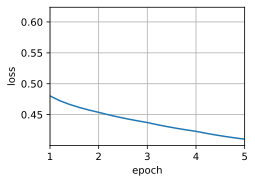

In [13]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

## 应用词嵌入
在训练word2vec模型之后，我们可以使用训练好模型中词向量的余弦相似度来从词表中找到与输入单词语义最相似的单词。


| 步骤    | 操作                          | 作用            |
| ----- | --------------------------- | ------------- |
| **①** | `W = embed.weight.data`     | 获取所有词向量       |
| **②** | `x = W[vocab[query_token]]` | 提取查询词向量       |
| **③** | 余弦相似度计算                     | 计算查询词与所有词的相似度 |
| **④** | `topk = torch.topk(...)`    | 找出最相似的 k+1 个词 |
| **⑤** | `for i in topk[1:]`         | 输出结果（排除自身）    |


$cos(W_{i},x)=\frac{\sum_{j=1}^{d}W_{i,j}\cdot x_{j}}{\sqrt[]{(\sum_{j=1}^{d}W_{i,j}^{2})\cdot (\sum_{j=1}^{d}x_{j}^{2})+\varepsilon } }$

$tpok_indices=argmax^{(k+1)}c_{i},i\in {1,2,...,V}$
- $c=[cos(W_{1},x),cos(W_{2},x),...,cos(W_{V},x)]$
- $argmax_{k+1}：$找出使$c_{i}$最大的k+1个索引
- 为什么k+1：因为查询词本身（$cos = 1$）必然排在第1位，需跳过
- 输出: $topk =[i_{1},i_{2},···,i_{k+1}]， 其中 c_{i_{1}} ≥ C_{i_{2}} ≥···≥ C_{i_{k+1}}$

In [14]:
'''
查询词：'chip'
返回数量：3个最相似的词
嵌入层：net[0]（skip-gram模型的输入嵌入层）
'''
def get_similar_tokens(query_token, k, embed):
    '''
    1. 获取词向量矩阵
    embed：PyTorch的Embedding层
    .weight.data：提取所有词的嵌入向量矩阵
    形状：(vocab_size,embed_dim)，每行是一个词的向量表示
    '''
    W = embed.weight.data
    '''
    2. 获取查询词的向量
    vocab[query_token]：查询词在词汇表中的索引（如'chip'→305）
    W[...]：从矩阵中提取该词对应的嵌入向量
    形状：(embed_dim,)，即查询词的特征向量
    '''
    x = W[vocab[query_token]]
    '''
    3. 计算余弦相似度：增加1e-9以获得数值稳定性
    分子：torch.mv(W,x)
        mv：矩阵-向量乘法
        计算所有词向量与查询词向量的点积（未归一化的相似度）
    分母：torch.sqrt(torch.sum(W*W,dim=1)*torch.sum(x*x)+1e-9)
        torch.sum(W*W,dim=1)：每个词向量的模长平方
        torch.sum(x*x)：查询词向量的模长平方
        +1e-9：数值稳定性，防止除零错误
    结果：cos是长度为vocab_size的向量，每个元素是查询词与对应词的余弦相似度（范围[-1,1]）
    余弦相似度公式：cos(u,v)=(u·v)/(||u||*||v||)
    '''
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    '''
    4. 找出最相似的k+1个词
    torch.topk(cos,k=k+1)：返回相似度最高的k+1个值及其索引
        返回(values,indices)元组
        [1]取索引部分
    为什么k+1：因为查询词本身相似度最高（1.0），会被排在第一位
    .cpu().numpy().astype('int32')：转移到CPU并转为NumPy数组
    '''
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    '''
    5. 输出结果（跳过查询词）
    topk[1:]:从第2个开始遍历（跳过第一个，即查询词本身）
    cos[i]获取该词的相似度分数
    vocab.to_tokens(i)将索引转换回对应的词
    输出格式:cosine sim=0.756:memory
    '''
    for i in topk[1:]:  # 删除输入词
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')
'''
为什么选择net[0]？
在skip-gram模型中：
    net[0]：输入嵌入层（中心词向量）→通常作为最终词向量
    net[1]：输出嵌入层（上下文词向量）
经验法则：训练完成后，输入嵌入层的词向量质量更好，更适合语义相似度计算
'''
get_similar_tokens('chip', 3, net[0])

cosine sim=0.815: microprocessor
cosine sim=0.712: intel
cosine sim=0.665: tandem
